In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [81]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import nltk
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification, XLMRobertaTokenizer, AdamW
import transformers
transformers.logging.set_verbosity_error()
import random

In [82]:
SEED = 3004

def set_seeds(seed):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seeds(seed=SEED)

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [84]:
train = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


## Simple Exploratory Data Analysis

In [86]:
train.describe(include='object')

,id,premise,hypothesis,lang_abv,language
count,12120,12120,12120,12120,12120
unique,12120,8209,12119,15,15
top,5130fd2cb5,and these comments were considered in formulat...,I am not sure.,en,English
freq,1,3,2,6870,6870


There are 8209 different premise and 12119 hypothesis

There are 15 languages with English account for about 55%

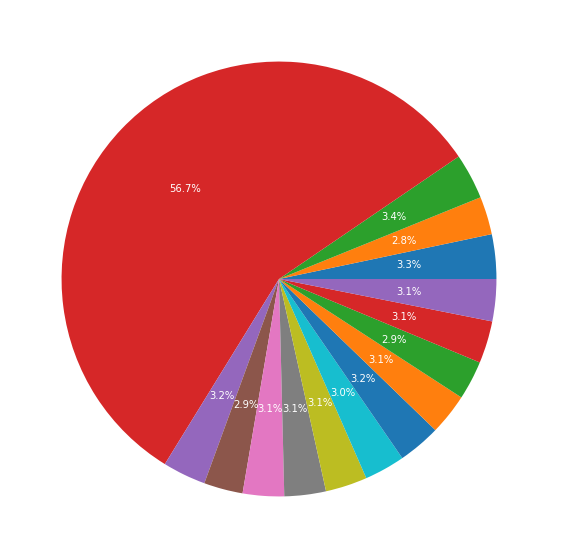

In [87]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%', textprops={'color':"w"})
plt.show()

In [88]:
temp = train.groupby('label').count()['premise'].reset_index().sort_values(by='premise',
                                                                           ascending=False)
temp.style.background_gradient(cmap='Reds')

,label,premise
0,0,4176
2,2,4064
1,1,3880


It seem our data is not imbalance 

<AxesSubplot:xlabel='label', ylabel='count'>

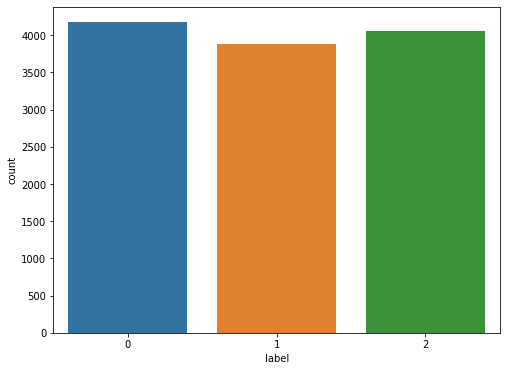

In [89]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train)

# Cleaning Data

In [90]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:
# Cleaning corpus
STOPWORDS = stopwords.words("english")

def clean_text(text, stopwords=STOPWORDS):
    text = text.lower()
    
    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)
    
    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()
    
    return text

In [15]:
train_df = train.copy()
test_df = test.copy()
train_df[train_df['lang_abv']=='env']['premise'] = train_df[train_df['lang_abv']=='env']['premise'].apply(clean_text)
train_df[train_df['lang_abv']=='env']['hypothesis'] = train_df[train_df['lang_abv']=='env']['hypothesis'].apply(clean_text)
test_df[test_df['lang_abv']=='env']['premise'] = test_df[test_df['lang_abv']=='env']['premise'].apply(clean_text)
test_df[test_df['lang_abv']=='env']['hypothesis'] = test_df[test_df['lang_abv']=='env']['hypothesis'].apply(clean_text)

In [16]:
# train val split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

test_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

(9696, 6)
(2424, 6)
(5195, 5)


# Define Hyperparameters and Tokenizer

In [96]:
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
PATIENCE = 3
EPOCHS = 5
MODEL_NAME='xlm-roberta-base'

TOKENIZER = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

Create custom dataset

In [18]:
class SherlockDataset(Dataset):
    def __init__(self, df, tokenizer=None, test=False):
#         super(SherlockDataset, self).__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.test = test
        
    def __getitem__(self, index):
        
        sentence1 = self.df.loc[index, 'premise']
        sentence2 = self.df.loc[index, 'hypothesis']
        
        encoded_dict = self.tokenizer.encode_plus(
                sentence1, sentence2,
                padding='max_length',
                add_special_tokens = True,
                max_length = MAX_LENGTH,     
                truncation = True,
                return_attention_mask = True,   
                return_tensors = 'pt' # return pytorch tensors
       )
        
        input_ids = encoded_dict['input_ids'][0]
        attention_mask = encoded_dict['attention_mask'][0]
        if not self.test:
            target = torch.tensor(self.df.loc[index, 'label'])
            return (input_ids, attention_mask, target)
        else:
            return (input_ids, attention_mask)
    
    def __len__(self):
        return len(self.df)

    
train_data = SherlockDataset(train_df, tokenizer=TOKENIZER)
val_data = SherlockDataset(val_df, tokenizer=TOKENIZER)
test_data = SherlockDataset(test_df, tokenizer=TOKENIZER, test=True)

train_data_loader = DataLoader(train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               num_workers=2
                               )

val_data_loader = DataLoader(val_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               num_workers=2
                               )

test_data_loader = DataLoader(test_data,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               num_workers=0
                               )

Text on Data Loader


In [19]:
batch = next(iter(train_data_loader))

# Send the data to the device
b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_labels = batch[2].to(device)

print(b_input_ids.shape)
print(b_input_mask.shape)
print(b_labels.shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


Define model, optimizer and loss function

In [21]:
# model = XLMRobertaForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     num_labels = 3, 
#     output_attentions = False,
#     output_hidden_states = False
# ).to(device)

# optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
# criterion = nn.CrossEntropyLoss()

In [22]:
class XLMRoberta_Arch(nn.Module):
    
    def __init__(self, model_name, n_classes, freeze_bert=None):
        
        super(XLMRoberta_Arch, self).__init__()
        self.roberta =  XLMRobertaModel.from_pretrained(
                                                        MODEL_NAME,
                                                        num_labels = n_classes, 
                                                        return_dict=False
                                                        )
        if freeze_bert:
            for p in self.roberta.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.roberta.config.hidden_size, self.roberta.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes) # (768,3)
    
    def forward(self, input_ids, attention_mask):
        _, output = self.roberta(
            input_ids = input_ids,
            attention_mask = attention_mask,
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

In [23]:
model = XLMRoberta_Arch(model_name=MODEL_NAME, n_classes=3).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
criterion = nn.CrossEntropyLoss()

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [24]:
# Text output of model

batch = next(iter(train_data_loader))

# Send the data to the device
b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_labels = batch[2].to(device)
# Run the model
outputs = model(input_ids=b_input_ids, 
                        attention_mask=b_input_mask,)

# The ouput is a tuple (loss, preds).
outputs

tensor([[-0.4038, -0.4310, -0.0963],
        [ 0.0686,  0.8773,  0.3417],
        [ 0.0579, -0.8363,  0.5464],
        [ 0.1343, -0.2870, -0.5347],
        [-0.1242,  0.4220,  1.3194],
        [-0.8942, -0.0379, -0.0854],
        [ 0.2279,  1.5140,  0.3386],
        [ 0.4576,  0.3515,  0.3174],
        [-1.1839,  0.8987, -0.2718],
        [ 0.1482, -0.3675, -0.9638],
        [ 0.7745,  0.0569,  0.5374],
        [ 0.8127, -0.8284, -0.7294],
        [ 0.5480, -0.7004,  0.0683],
        [-1.1770, -0.0377,  0.5071],
        [ 1.2361,  0.2473, -0.1801],
        [-0.6710, -1.2382, -1.3220]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [26]:
preds = outputs.detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis=1)

val_acc = accuracy_score(y_true, y_pred)

val_acc

0.4375

Trainer

In [28]:
class Trainer(object):
    def __init__(self, model, device, optimizer, loss_fn, scheduler=None):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_epoch(self, data_loader):
        self.model.train()
        train_loss = 0
        torch.set_grad_enabled(True)
        pbar = tqdm(enumerate(data_loader), total = len(data_loader))
        for i, batch in pbar:

            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)

            self.model.zero_grad()
            output = self.model(b_input_ids, b_input_mask,
                            )
#             output = output.logits
            loss = self.loss_fn(output, b_labels)
            
            self.optimizer.zero_grad()

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            self.optimizer.step()

            train_loss += loss.item()
#             print('loss batch:', loss)
#         del b_input_ids, b_input_mask, b_labels, loss
#         print(f'Average Training loss: {round(train_loss / len(data_loader), 5)}')
            train_desc = f'Loss: {train_loss/(i+1):.4f}'
            pbar.set_description(desc = train_desc)
        return train_loss / len(data_loader)
    
    def eval_epoch(self, data_loader):
        self.model.eval()
        torch.set_grad_enabled(False)
        eval_loss = 0
        targets_list = []
        with torch.inference_mode():
            pbar = tqdm(enumerate(data_loader), total = len(data_loader))
            for i, batch in pbar:

                b_input_ids = batch[0].to(self.device)
                b_input_mask = batch[1].to(self.device)
                b_labels = batch[2].to(self.device)

                output = self.model(b_input_ids, b_input_mask,
                             )
#                 output = output.logits
                loss = self.loss_fn(output, b_labels)
                eval_loss += loss.item()

                preds = output

                # Move preds to the CPU
                val_preds = preds.detach().cpu().numpy()
                
                # Move the labels to the cpu
                targets_np = b_labels.to('cpu').numpy()

                targets_list.extend(targets_np)

                if i == 0:  # first batch
                    stacked_val_preds = val_preds

                else:
                    stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
                val_desc = f'Loss: {eval_loss/(i+1):.4f}'
                pbar.set_description(desc = val_desc)
        # Calculate the validation accuracy
        y_true = targets_list
        y_pred = np.argmax(stacked_val_preds, axis=1)
        print(y_pred)
        val_acc = accuracy_score(y_true, y_pred)
        
        
#         print('Average Val loss:' , eval_loss/len(data_loader))
#         print('Val acc: ', val_acc)

#         del b_input_ids, b_input_mask, b_labels, loss
		
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return eval_loss/len(data_loader), val_acc
    
    def train(self, epochs, patience, train_loader, val_loader):
        best_val_loss = np.inf
        for epoch in range(epochs):

            avg_train_loss = self.train_epoch(data_loader=train_loader)
            avg_val_loss, val_acc = self.eval_epoch(data_loader=val_loader)
            if self.scheduler:    
                self.scheduler.step(avg_val_loss)
            
            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = self.model
                torch.save(self.model.state_dict(), 'model.pt')
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            print(
                f"Epoch: {epoch} | "
                f"train_loss: {avg_train_loss:.5f}, "
                f"val_loss: {avg_val_loss:.5f}, "
                f"val_acc: {val_acc:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )

        return best_model

Training model on train and eval set

In [29]:
trainer = Trainer(
    model=model, device=device, optimizer=optimizer,
    loss_fn=criterion, scheduler=None)

In [30]:
best_model = trainer.train(EPOCHS, PATIENCE, train_data_loader, val_data_loader)

Loss: 0.9183: 100%|██████████| 152/152 [00:19<00:00,  7.67it/s]


[1 2 0 ... 0 1 0]
Epoch: 0 | train_loss: 1.10640, val_loss: 0.91834, val_acc: 0.59158, lr: 2.00E-05, _patience: 3


Loss: 0.7741: 100%|██████████| 152/152 [00:19<00:00,  7.70it/s]


[0 1 2 ... 1 1 0]
Epoch: 1 | train_loss: 0.85434, val_loss: 0.77414, val_acc: 0.66254, lr: 2.00E-05, _patience: 3


Loss: 0.8086: 100%|██████████| 152/152 [00:19<00:00,  7.70it/s]


[2 0 0 ... 1 0 1]
Epoch: 2 | train_loss: 0.68208, val_loss: 0.80865, val_acc: 0.67492, lr: 2.00E-05, _patience: 2


Loss: 0.7928: 100%|██████████| 152/152 [00:19<00:00,  7.71it/s]


[0 2 1 ... 2 0 1]
Epoch: 3 | train_loss: 0.53499, val_loss: 0.79281, val_acc: 0.69389, lr: 2.00E-05, _patience: 1


Loss: 0.9787: 100%|██████████| 152/152 [00:19<00:00,  7.67it/s]


[1 1 0 ... 0 1 2]
Stopping early!


# Inference

In [114]:
model = XLMRoberta_Arch(model_name=MODEL_NAME, n_classes=3).to(device)
model.load_state_dict(torch.load("model.pt"))
model.to(device)

In [115]:
sentence1 = train_df.loc[1, 'premise']
sentence2 = train_df.loc[1, 'hypothesis']
        
encoded_dict = TOKENIZER.encode_plus(
        sentence1, sentence2,
        padding='max_length',
        add_special_tokens = True,
        max_length = MAX_LENGTH,     
        truncation = True,
        return_attention_mask = True,   
        return_tensors = 'pt' # return pytorch tensors
)

input_ids = encoded_dict['input_ids']
attention_mask = encoded_dict['attention_mask']

In [116]:
model.eval()
output = model(input_ids.to(device), attention_mask.to(device),
                             )
class_to_index = ['Entailment', 'Neutral','Contracdiction']
pred = torch.argmax(output, 1).item()
class_to_index[pred]

'Contracdiction'